In [1]:
import enum
class Primitive(enum.Enum):
    rho, u, p = 0, 1, 2
class Conservative(enum.Enum):
    mass, momentum, energy = 0, 1, 2

GAMMA = 1.4
  
def flux(q0, flux_type: Conservative):
    p = (GAMMA - 1) * (q0[Conservative.energy.value] - 0.5 * q0[Conservative.momentum.value]**2 / q0[Conservative.mass.value])
    if flux_type == Conservative.mass:
        return q0[Conservative.momentum.value]
    if flux_type == Conservative.momentum:
        return (q0[Conservative.momentum.value]**2) / q0[Conservative.mass.value] + p
    if flux_type == Conservative.energy:
        return (q0[Conservative.momentum.value] * q0[Conservative.energy.value] + p * q0[Conservative.momentum.value]) / q0[Conservative.mass.value]

def back_to_primitive(q0, primitive_type: Primitive):
    if primitive_type == Primitive.rho:
        return q0[Conservative.mass.value]
    if primitive_type == Primitive.u:
        return q0[Conservative.momentum.value] / q0[Conservative.mass.value]
    if primitive_type == Primitive.p:
        return (GAMMA - 1) * (q0[Conservative.energy.value] - 0.5 * q0[Conservative.momentum.value]**2 / q0[Conservative.mass.value])

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from weno5_scheme import weno5_reconstruction
from rk3 import rk3

ghost_cells_n = 3

x_l, x_r, t = 0, 1, 0.2
nx = 200
dt = 0.0001
dx = (x_r - x_l) / nx
nt = int(t / dt)

x = np.linspace(dx / 2 - ghost_cells_n * dx, x_r - dx / 2 + ghost_cells_n * dx, nx +2 * ghost_cells_n)

# primitive states
u = np.zeros((nt + 1, len(Primitive), nx  + 2 * ghost_cells_n))
for i, pos in enumerate(x):
    u[0, Primitive.rho.value, i] = 1.0 if pos < 0.5 else 0.125
    u[0, Primitive.u.value, i] = 0.0
    u[0, Primitive.p.value, i] = 1.0 if pos < 0.5 else 0.1

rho0, u0, p0 = u[0, Primitive.rho.value], u[0, Primitive.u.value], u[0, Primitive.p.value]

q = np.zeros((nt + 1, len(Primitive), nx  + 2 * ghost_cells_n))

q[0, Conservative.mass.value] = rho0
q[0, Conservative.momentum.value] = rho0 * u0
q[0, Conservative.energy.value] = rho0 * (p0 / (rho0 * (GAMMA - 1.0)) + 0.5 * u0**2)

### Primitive states

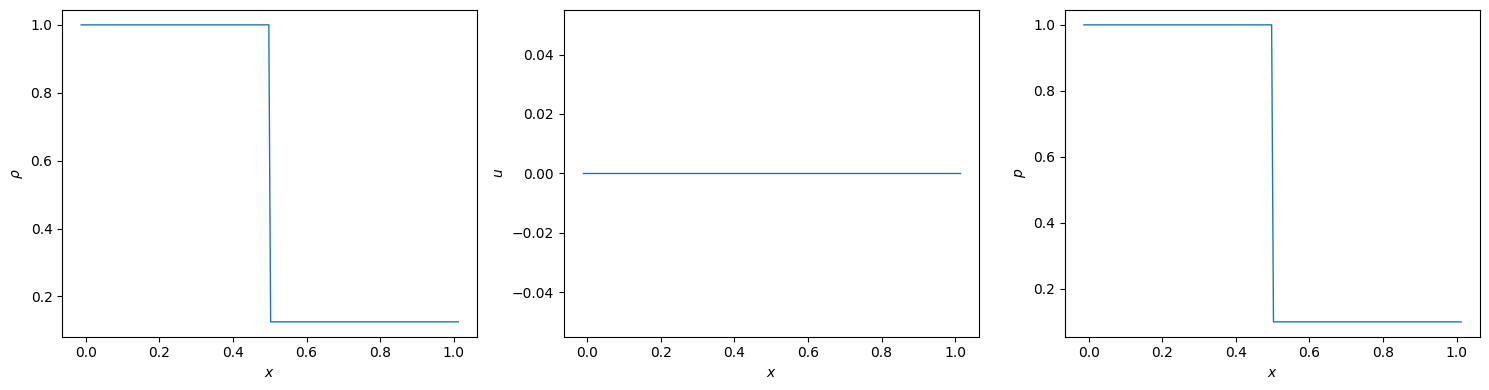

In [3]:
states = (r"$\rho$", r"$u$", r"$p$")
plt.figure(figsize=(15, 4), dpi=100)
for i, state in enumerate(Primitive, 1):
    plt.subplot(1, 3, i)
    plt.plot(x, u[0, state.value], linewidth=1)
    plt.xlabel("$x$")
    plt.ylabel(states[i-1])
plt.tight_layout()
plt.show()

### Conservative states

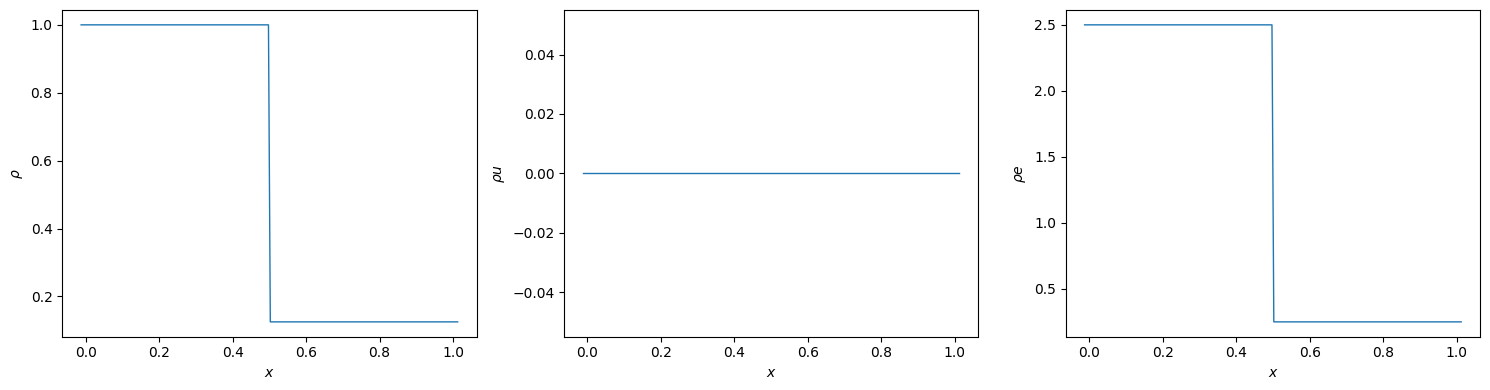

In [4]:
states = (r"$\rho$", r"$\rho u$", r"$\rho e$")
plt.figure(figsize=(15, 4), dpi=100)
for i, state in enumerate(Conservative, 1):
    plt.subplot(1, 3, i)
    plt.plot(x, q[0, state.value], linewidth=1)
    plt.xlabel("$x$")
    plt.ylabel(states[i-1])
plt.tight_layout()
plt.show()

In [5]:
rhs_buffer = np.zeros((len(Conservative), nx))
conser_values_L, conser_values_R = np.zeros((len(Conservative), nx+1)), np.zeros((len(Conservative), nx+1))
f = np.zeros((len(Conservative), nx+1))

# for Dirichlet boundary (for this case, symmetric boundary is possible)
def update_ghost_cells(buffer):
    buffer[:, 0], buffer[:, 1], buffer[:, 2] = buffer[:, 5], buffer[:, 4], buffer[:, 3]
    buffer[:, -1], buffer[:, -2], buffer[:, -3] = buffer[:, -6], buffer[:, -5], buffer[:, -4]
    

def right_hand_side(q0):
    # update first term
    for i in range(nx + 1):
        for state in Conservative:
            value = (q0[state.value, i], q0[state.value, i + 1], q0[state.value, i + 2], q0[state.value, i + 3], q0[state.value, i + 4])
            conser_values_L[state.value, i] = weno5_reconstruction(value)
            
            value = (q0[state.value, i+5], q0[state.value, i + 4], q0[state.value, i + 3], q0[state.value, i + 2], q0[state.value, i + 1])
            conser_values_R[state.value, i] = weno5_reconstruction(value)
            
    for state in Conservative:
        f[state.value] = 0.5 * (flux(conser_values_L, state) + flux(conser_values_R, state))

    # update second term 
    # TODO: better logic
    for i in range(nx + 1):
        rhoL = conser_values_L[Conservative.mass.value, i]
        uL = conser_values_L[Conservative.momentum.value, i] / rhoL
        eL = conser_values_L[Conservative.energy.value, i] / rhoL
        pL = (GAMMA - 1) * (eL * rhoL - 0.5 * rhoL * uL**2)
        hL = eL + pL / rhoL
        
        rhoR = conser_values_R[Conservative.mass.value, i]
        uR = conser_values_R[Conservative.momentum.value, i] / rhoR
        eR = conser_values_R[Conservative.energy.value, i] / rhoR
        pR = (GAMMA - 1) * (eR * rhoR - 0.5 * rhoR * uR**2)
        hR = eR + pR / rhoR
        
        alpha = 1 / (np.sqrt(abs(rhoL)) + np.sqrt(abs(rhoR)))
        
        uu = (np.sqrt(abs(rhoL))*uL + np.sqrt(abs(rhoR))*uR)*alpha
        hh = (np.sqrt(abs(rhoL))*hL + np.sqrt(abs(rhoR))*hR)*alpha
        aa = np.sqrt(abs((GAMMA - 1) * (hh - 0.5 * uu**2)))
        
        ps = abs(aa + uu)
        
        for state in Conservative:
            f[state.value, i] -= 0.5 * ps * (conser_values_R[state.value, i] - conser_values_L[state.value, i])

    for i in range(nx):
        for state in Conservative:
            rhs_buffer[state.value, i] = - (f[state.value, i+1] - f[state.value, i]) / dx
    return rhs_buffer
    

In [6]:
intermediate = np.zeros_like(q[0])
to_update_slice = slice(ghost_cells_n, nx+ghost_cells_n)

for i in range(1, nt+1):
    
    buffer = right_hand_side(q[i-1])
    intermediate[:, to_update_slice] = rk3(1, q[i-1, :, to_update_slice], buffer, dt, None)
    update_ghost_cells(intermediate)
    
    buffer = right_hand_side(intermediate)
    intermediate[:, to_update_slice] = rk3(2, q[i-1, :, to_update_slice], buffer, dt, intermediate[:, to_update_slice])
    update_ghost_cells(intermediate)
    
    buffer = right_hand_side(intermediate)
    intermediate[:, to_update_slice] = rk3(3, q[i-1, :, to_update_slice], buffer, dt, intermediate[:, to_update_slice])
    update_ghost_cells(intermediate)
    
    q[i] = intermediate
    

### Note that $\rho e$ are plotted, not $e$

### Pressure profile in his paper is wrong. He forgot multiplying $0.5$ for kinetic energy

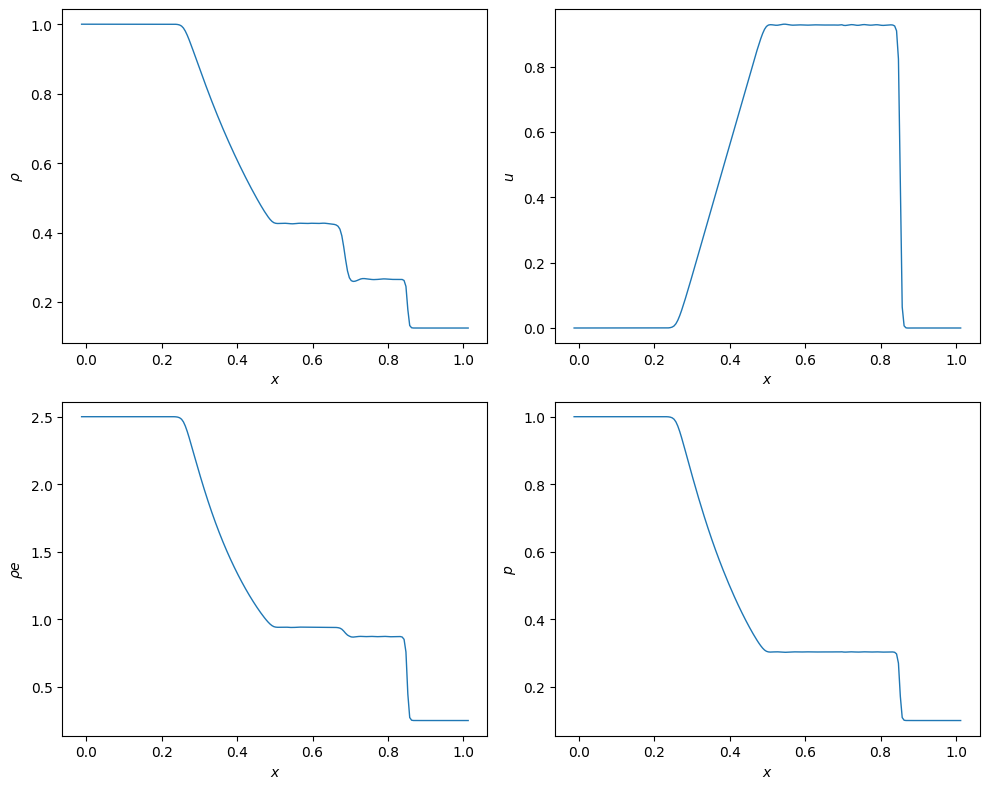

In [7]:
plt.figure(figsize=(10,8), dpi=100)
states = (r"$\rho$", r"$u$", r"$\rho e$", r"$p$")
profiles = (back_to_primitive(q[-1], Primitive.rho), back_to_primitive(q[-1], Primitive.u), q[-1, Conservative.energy.value], back_to_primitive(q[-1], Primitive.p))
for i, (state, profile) in enumerate(zip(states, profiles)):
    plt.subplot(2, 2, i+1)
    plt.plot(x, profile, linewidth=1)
    plt.xlabel("$x$")
    plt.ylabel(state)
plt.tight_layout()